In [2]:
# 📚 Librerías
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import cohen_kappa_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.utils import resample

c:\Users\Jhonr\anaconda3\envs\ods_evaluacion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Limpieza estilo BERT
def limpiar_bert(texto):
    if not texto or str(texto).strip() == '':
        return 'Texto vacío'
    texto_limpio = BeautifulSoup(str(texto), "html.parser").get_text().lower()
    texto_limpio = re.sub(
        r'\b(introduction|aims|objectives|methods|results|discussion|conclusion|background|purpose|scope)\b[:\s]*',
        '', texto_limpio, flags=re.IGNORECASE)
    texto_limpio = re.sub(
        r'\b(this study (aims|explores|presents)|we (present|explore|investigate)|the purpose of this (study|paper))\b',
        '', texto_limpio)
    texto_limpio = re.sub(r'[^a-z0-9\s.,-]', '', texto_limpio)
    texto_limpio = re.sub(r'\s+', ' ', texto_limpio).strip()
    return texto_limpio


In [4]:
# Cargar inferencia 
df = pd.read_excel("C:/Users/Jhonr/Project_ODS_BERT/Resultados_2018-2024/Predicciones_2018_2024_Modelo_Final.xlsx")
df["clean"] = df["Abstract_BERT"].astype(str).apply(limpiar_bert)




In [5]:
# ==================== NB_ODS_3 ====================
df_3 = pd.read_excel("C:/Users/Jhonr/Project_ODS_BERT/Muestra_Limpia_ODS_3_9_Otros.xlsx")
df_3["clean"] = df_3["Abstract"].astype(str).apply(limpiar_bert)
df_3["label"] = df_3["ODS"].apply(lambda x: "ODS 3" if x == "ODS 3" else "NO_3")

vec_3 = TfidfVectorizer(max_features=1000)
X3 = vec_3.fit_transform(df_3["clean"])
y3 = df_3["label"]
nb3 = MultinomialNB(alpha=0.5).fit(X3, y3)
df["NB_ODS_3"] = nb3.predict(vec_3.transform(df["clean"]))

# ==================== NB_ODS_9 ====================
df_9 = pd.read_excel("C:/Users/Jhonr/Project_ODS_BERT/Muestra_Estratificada_6_7_9_13_OTROS-GPT.xlsx")
df_9["clean"] = df_9["Abstract"].astype(str).apply(limpiar_bert)
df_9 = df_9[df_9["ODS"].isin(["ODS 9", "OTROS"])]

vec_9 = TfidfVectorizer(max_features=1000)
X9 = vec_9.fit_transform(df_9["clean"])
y9 = df_9["ODS"]
nb9 = MultinomialNB(alpha=0.5).fit(X9, y9)
df["NB_ODS_9"] = nb9.predict(vec_9.transform(df["clean"]))

# ==================== NB_ODS_6_7_13 ====================
df_yake = pd.read_excel("C:/Users/Jhonr/Project_ODS_BERT/Muestra_Estratificada_6_7_9_13_OTROS-Coseno.xlsx")
df_yake["clean"] = df_yake["Abstract"].astype(str).apply(limpiar_bert)
df_yake["label"] = df_yake["ODS"].apply(lambda x: "ODS_6_7_13" if x in ["ODS 6", "ODS 7", "ODS 13"] else "OTROS")
minority = df_yake[df_yake["label"] == "ODS_6_7_13"]
majority = df_yake[df_yake["label"] == "OTROS"]
minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=42)
df_bal = pd.concat([minority_up, majority])

vec_yake = TfidfVectorizer(max_features=1000)
Xy = vec_yake.fit_transform(df_bal["clean"])
yy = df_bal["label"]
nb_yake = MultinomialNB(alpha=0.5).fit(Xy, yy)
df["NB_ODS_6_7_13"] = nb_yake.predict(vec_yake.transform(df["clean"]))

In [6]:
# ==================== Evaluación NB vs modelos principales ====================
print("\n✅ COHEN KAPPA SCORES")
kappa_3 = cohen_kappa_score(df["NB_ODS_3"], df["ODS_Predicho"].apply(lambda x: "ODS 3" if x == "ODS 3" else "NO_3"))
print(f"Kappa NB_ODS_3 vs BERT: {kappa_3:.4f}")
kappa_9 = cohen_kappa_score(df["NB_ODS_9"], df["ODS_Predicho"].apply(lambda x: x if x == "ODS 9" else "OTROS"))
print(f"Kappa NB_ODS_9 vs BERT: {kappa_9:.4f}")
kappa_yake = cohen_kappa_score(df["NB_ODS_6_7_13"], df["prediccion_yake"].apply(lambda x: "ODS_6_7_13" if x in ["ODS 6", "ODS 7", "ODS 13"] else "OTROS"))
print(f"Kappa NB_ODS_6_7_13 vs YAKE: {kappa_yake:.4f}")


✅ COHEN KAPPA SCORES
Kappa NB_ODS_3 vs BERT: 0.7258
Kappa NB_ODS_9 vs BERT: 0.5982
Kappa NB_ODS_6_7_13 vs YAKE: 0.3060


In [7]:
# ==================== modelo_final: CON YAKE ====================
def clase_final_yake(row):
    if row["ODS_Predicho"] == "ODS 3":
        return "BERT_3"
    elif row["ODS_Predicho"] == "ODS 9":
        return "BERT_9"
    elif row["prediccion_yake"] in ["ODS 6", "ODS 7", "ODS 13"]:
        return "YAKE_" + row["prediccion_yake"].split()[1]
    else:
        return "OTROS"
df["modelo_final_yake"] = df.apply(clase_final_yake, axis=1)

In [8]:
# ==================== modelo_final: SIN YAKE ====================
def clase_final_sin_yake(row):
    if row["ODS_Predicho"] == "ODS 3":
        return "BERT_3"
    elif row["ODS_Predicho"] == "ODS 9":
        return "BERT_9"
    else:
        return "OTROS"
df["modelo_final_sin_yake"] = df.apply(clase_final_sin_yake, axis=1)

In [9]:
# ==================== Clustering ====================
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df["clean"].tolist(), show_progress_bar=True)
kmeans = KMeans(n_clusters=6, random_state=42)
df["Cluster"] = kmeans.fit_predict(embeddings)

# Evaluación con YAKE
y_yake = LabelEncoder().fit_transform(df["modelo_final_yake"])
nmi_yake = normalized_mutual_info_score(y_yake, df["Cluster"])
ari_yake = adjusted_rand_score(y_yake, df["Cluster"])
sil_yake = silhouette_score(embeddings, df["Cluster"])

print("\n Clustering Metrics CON YAKE")
print(f"NMI: {nmi_yake:.4f}")
print(f"ARI: {ari_yake:.4f}")
print(f"Silhouette: {sil_yake:.4f}")

# Evaluación sin YAKE
y_sin = LabelEncoder().fit_transform(df["modelo_final_sin_yake"])
nmi_sin = normalized_mutual_info_score(y_sin, df["Cluster"])
ari_sin = adjusted_rand_score(y_sin, df["Cluster"])
sil_sin = silhouette_score(embeddings, df["Cluster"])

print("\n Clustering Metrics SIN YAKE")
print(f"NMI: {nmi_sin:.4f}")
print(f"ARI: {ari_sin:.4f}")
print(f"Silhouette: {sil_sin:.4f}")


Batches: 100%|██████████| 726/726 [15:09<00:00,  1.25s/it]  
c:\Users\Jhonr\anaconda3\envs\ods_evaluacion\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



 Clustering Metrics CON YAKE
NMI: 0.2912
ARI: 0.1532
Silhouette: 0.0344

 Clustering Metrics SIN YAKE
NMI: 0.2863
ARI: 0.1532
Silhouette: 0.0344


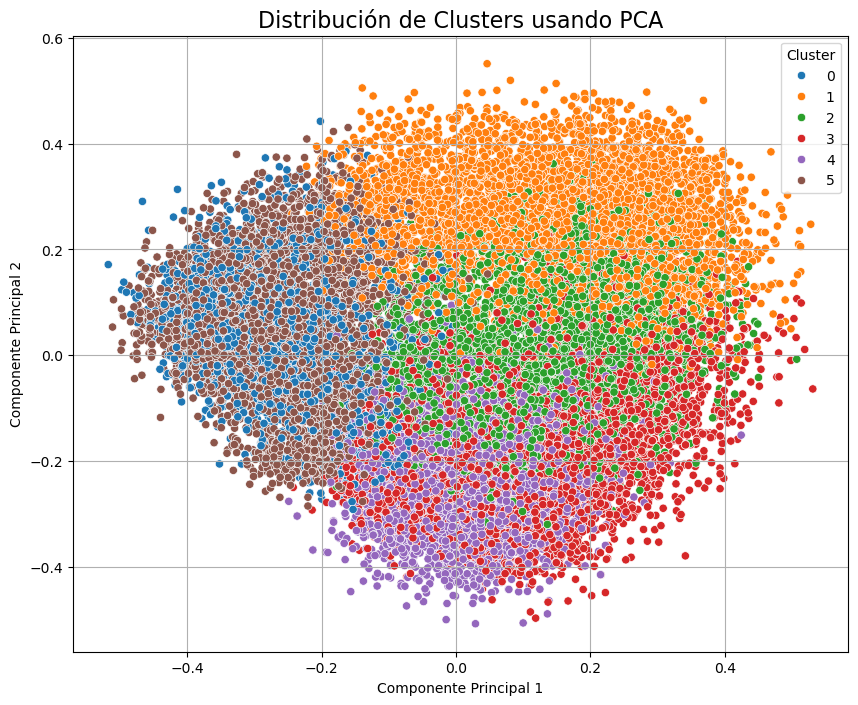

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Reducir los embeddings a 2 dimensiones usando PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Crear el scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_2d[:, 0], 
    y=embeddings_2d[:, 1], 
    hue=df["Cluster"], 
    palette="tab10", 
    legend="full"
)
plt.title('Distribución de Clusters usando PCA', fontsize=16)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


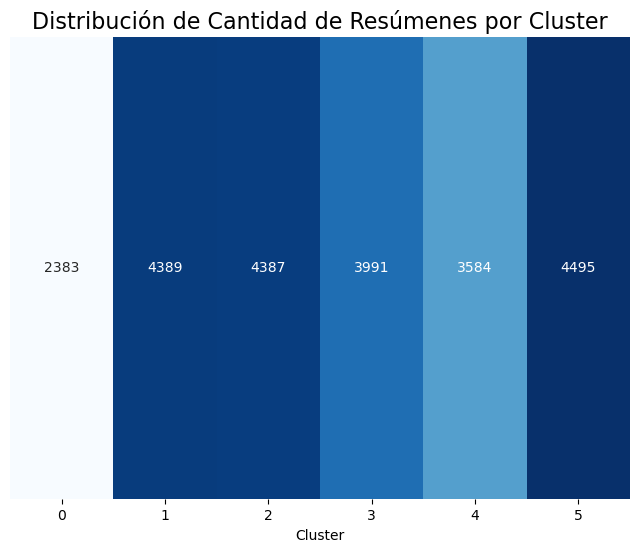

In [11]:
import seaborn as sns

# Contar muestras por cluster
cluster_counts = df["Cluster"].value_counts().sort_index()

# Crear un heatmap simple
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_counts.to_frame().T, cmap="Blues", annot=True, fmt='d', cbar=False)
plt.title('Distribución de Cantidad de Resúmenes por Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.yticks([])
plt.show()


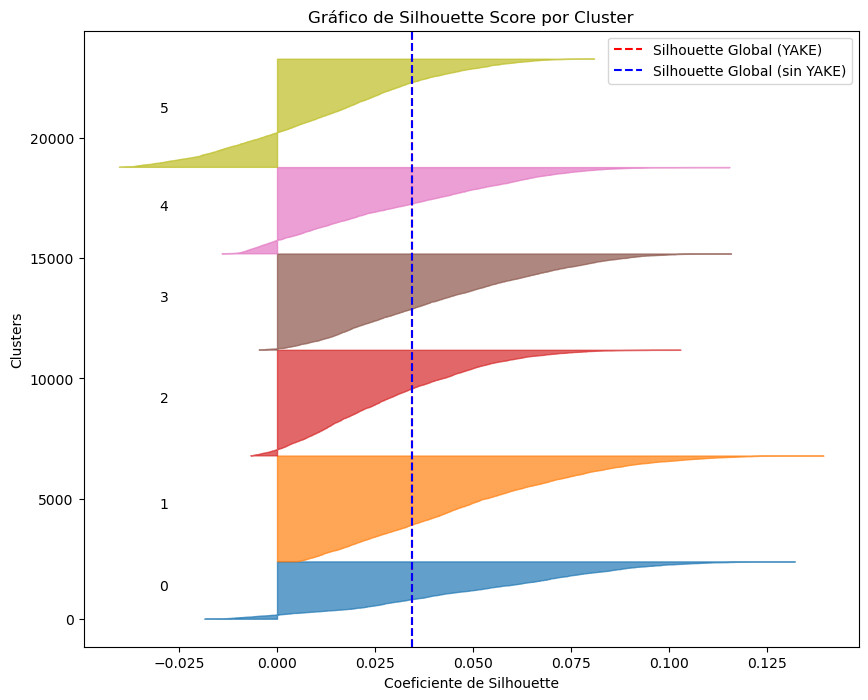

In [12]:
from sklearn.metrics import silhouette_samples
import numpy as np

# Calcular Silhouette Score individual
silhouette_vals = silhouette_samples(embeddings, df["Cluster"])

# Crear un gráfico por cluster
y_lower = 10
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(6):  # Ajusta el número de clusters
    cluster_silhouette_vals = silhouette_vals[df["Cluster"] == i]
    cluster_silhouette_vals.sort()
    
    y_upper = y_lower + len(cluster_silhouette_vals)
    color = plt.cm.tab10(float(i) / 6)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.03, (y_lower + y_upper) / 2, str(i))
    y_lower = y_upper + 10  # espacio entre clusters

ax.set_xlabel('Coeficiente de Silhouette')
ax.set_ylabel('Clusters')
ax.set_title('Gráfico de Silhouette Score por Cluster')
ax.axvline(x=sil_yake, color="red", linestyle="--", label="Silhouette Global (YAKE)")
ax.axvline(x=sil_sin, color="blue", linestyle="--", label="Silhouette Global (sin YAKE)")
ax.legend()
plt.show()
